# NLP Disaster Tweets Classification (LSTM + Doc2Vec)


In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')

#Keras
import keras
from keras import layers

from sklearn.model_selection import train_test_split

import itertools

[nltk_data] Downloading package wordnet to C:\Users\Michael
[nltk_data]     Christensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Michael
[nltk_data]     Christensen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Table of Contents
1. [Introduction](#introduction)
2. [Exploratory Data Analaysis](#paragraph1)
3. [Model Architecture (LSTM)](#paragraph2)
4. [Results & Analysis](#paragraph3)

## 1. Introduction <a name="introduction"></a>

GitHub link: https://github.com/machristensen1/nlp-disaster-tweets

https://www.kaggle.com/competitions/nlp-getting-started
<blockquote>
Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.
</blockquote>

Our goal is to be able to categorize whether or not a tweet is announcing a disaster using NLP. We will be achieving this through LSTM and Doc2Vec. The advantage of Doc2Vec is that it allows us to take each tweet in it's entirety and include important context - Word2Vec might be able to achieve a decent result, but we may run into classification issues when people use metaphorical terms such as 'ablaze' to describe a sunset, as per the example in the Kaggle competition.

## 2. Exploratory Data Analysis <a name="paragraph1"></a>

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
df_train['target'].describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [7]:
#Impute missing values
df_train['keyword'] = df_train['keyword'].fillna('no_keyword')
df_train['location'] = df_train['location'].fillna('no_location')
df_test['keyword'] = df_test['keyword'].fillna('no_keyword')
df_test['location'] = df_test['location'].fillna('no_location')

In [8]:
df_train.head()

,id,keyword,location,text,target
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


### Data Visualization
As we can see from below, there does appear to be a difference between the distributions of word counts and unique word counts when a tweet is labeled as a disaster.

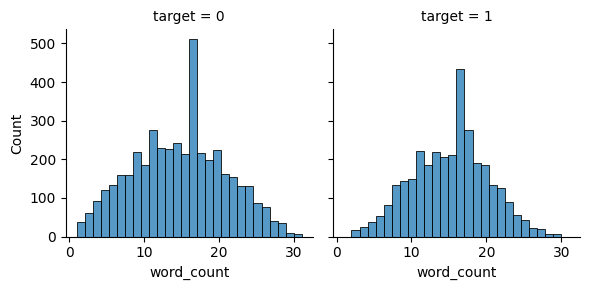

In [9]:
#Total overall wordcount
df_train['word_count'] = df_train['text'].str.split().map(lambda x: len(x))
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))

g = sns.FacetGrid(df_train, col = "target")
g.map(sns.histplot,"word_count")


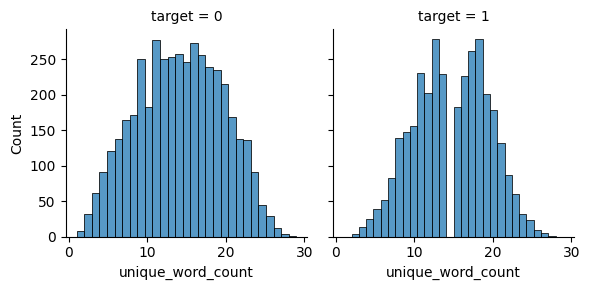

In [10]:
g = sns.FacetGrid(df_train, col = "target")
g.map(sns.histplot,"unique_word_count")

<Axes: xlabel='word_count', ylabel='Count'>

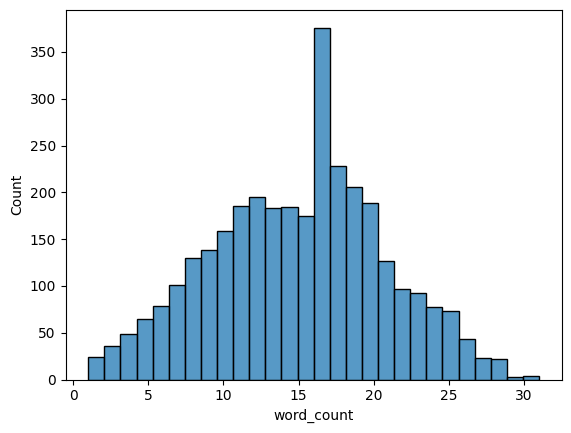

In [11]:
df_test['word_count'] = df_test['text'].str.split().map(lambda x: len(x))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

sns.histplot(df_test['word_count'])


<Axes: xlabel='unique_word_count', ylabel='Count'>

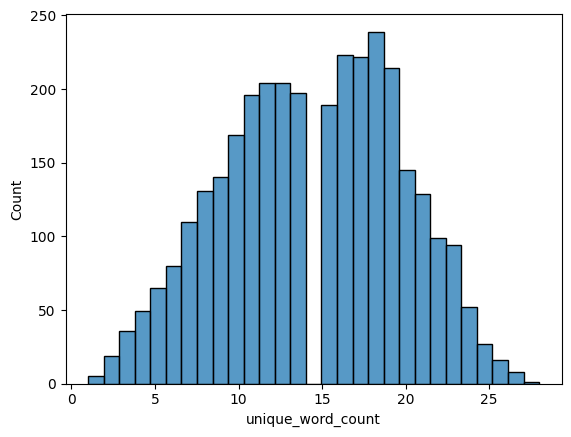

In [12]:
sns.histplot(df_test['unique_word_count'])

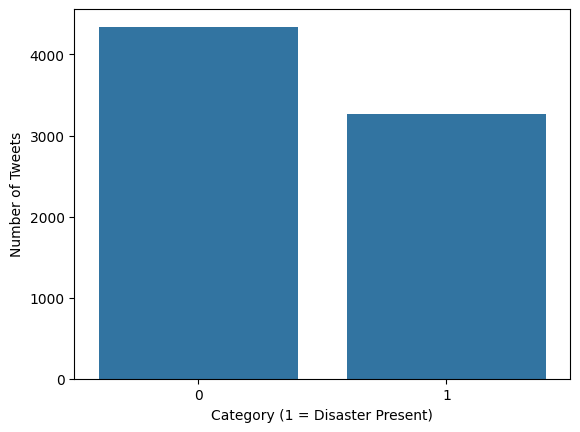

In [13]:
target_counts = df_train['target'].value_counts()

plt.figure()

sns.barplot(target_counts.values)
plt.ylabel('Number of Tweets')
plt.xlabel('Category (1 = Disaster Present)')
plt.show()

In [14]:
pt = round(100*np.mean(df_train['target']),2)
print(f"{pt}% of the training set is labeled as a disaster.")

42.97% of the training set is labeled as a disaster.


<Axes: >

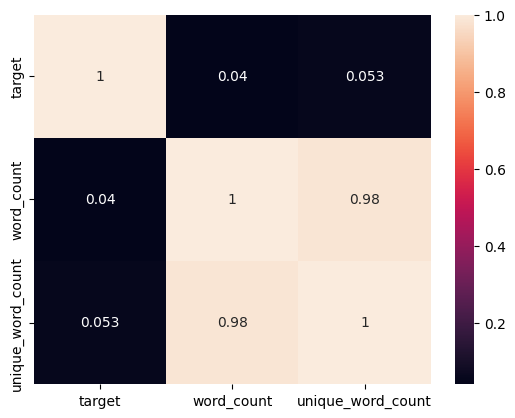

In [15]:
corr = df_train.drop(['id'], axis = 1).corr(numeric_only=True)
sns.heatmap(corr, annot = True)

There only appears to be a mild correlation between word coutns and target: `0.053`.

## Model Architecture <a name="paragraph2"></a>

1. Clean data
2. Tag documents for Doc2Vec
3. Build Doc2Vec Model & Vocab


### Text Cleaning & Tagging
We're going to normalize the text by switching to lowercase, removing links and punctuation, removing stopwords, and lemmatizing. We won't be stemming as tense is likely important to context for disaster tweet classification, present tense could imply on ongoing disaster.

We used the following Kaggle notebook to help derive the Doc2Vec architecture, as well as the `gensim` documentation.

https://www.kaggle.com/code/khotijahs1/using-lstm-for-nlp-text-classification

https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py

In [16]:
stopwords = nltk.corpus.stopwords.words('english')
def clean(text):
    st = ""
    
    # Remove Punctuation & links w regex, force lowercase
    text = text.lower()
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    text = st.join([char if char not in string.punctuation else ' ' for char in text]) 

    #Remove stopwords
    text = " ".join([word for word in text.split() if word not in stopwords])

    #Tokenize & Lemmatize
    tknz = nltk.tokenize.WhitespaceTokenizer()
    lmtz = WordNetLemmatizer()
    for word in tknz.tokenize(text): 
        st = st + lmtz.lemmatize(word) + " "
    text = re.split('\s+',st)
    return text
    

In [17]:
#Tag documents for doc2vec
X_train, X_val = train_test_split(df_train, test_size = 0.2, random_state = 0)

X_train_tagged = X_train.apply(lambda x:TaggedDocument(words = clean(x['text']), tags = [x['target']]),axis = 1)
X_val_tagged = X_val.apply(lambda x:TaggedDocument(words = clean(x['text']), tags = [x['target']]),axis = 1)

In [18]:
X_train_tagged.values

array([TaggedDocument(words=['ted', 'cruz', 'fire', 'back', 'jeb', 'amp', 'bush', 'lose', 'republican', 'like', 'jeb', 'amp', 'mitt', 'video', ''], tags=[0]),
       TaggedDocument(words=['first', 'year', 'forest', 'service', 'spent', 'half', 'annual', 'budget', 'fighting', 'fire', 'climatechange', ''], tags=[1]),
       TaggedDocument(words=['lightseraphs', 'pissed', 'could', 'pikachu', 'electrocute', ''], tags=[0]),
       ...,
       TaggedDocument(words=['great', 'british', 'bake', 'offs', 'back', 'dorrets', 'chocolate', 'gateau', 'collapsed', 'jan', 'moir', ''], tags=[1]),
       TaggedDocument(words=['black', 'eye', '9', 'space', 'battle', 'occurred', 'star', 'o784', 'involving', '2', 'fleet', 'totaling', '3934', 'ship', '7', 'destroyed', ''], tags=[0]),
       TaggedDocument(words=['mikeparractor', 'absolutely', 'devastated', 'actor', 'miss', 'rossbarton', 'every', 'girl', 'love', 'bad', 'boy', ''], tags=[0])],
      dtype=object)

In [19]:
#Passthrough Keras Tokenizer before model building
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'].values)
X = tokenizer.texts_to_sequences(df_train['text'].values)
X = pad_sequences(X)
X.shape

(7613, 33)

In [20]:
#Build vocab for Doc2Vec
X_train_tagged.head()

d2vm = Doc2Vec(vector_size = 25, min_count = 2, epochs = 30)
d2vm.build_vocab(X_train_tagged.values)

In [21]:
d2vm.train(X_train_tagged, total_examples = d2vm.corpus_count, epochs = d2vm.epochs)

In [22]:
print(f"Word 'fire' appeared {d2vm.wv.get_vecattr('disaster', 'count')} times in the training corpus.")

Word 'fire' appeared 122 times in the training corpus.


In [23]:
#similarity for disaster tweets
d2vm.wv.most_similar(positive = 1, topn = 10)

[('detouring', 0.8935810923576355),
 ('acre', 0.8922364711761475),
 ('township', 0.8891415596008301),
 ('dr', 0.881637692451477),
 ('chp', 0.8790845274925232),
 ('office', 0.8786222338676453),
 ('ablaze', 0.8784908652305603),
 ('newyork', 0.8774296641349792),
 ('langley', 0.8727045059204102),
 ('rocky', 0.8717607855796814)]

In [24]:
#Similarity for non-disaster tweets
d2vm.wv.most_similar(positive = 0, topn = 10)

[('usa', 0.872025191783905),
 ('100', 0.8694365620613098),
 ('bumper', 0.8648096323013306),
 ('l', 0.8622252941131592),
 ('title', 0.8595365881919861),
 ('google', 0.8556082248687744),
 ('imported', 0.8551681041717529),
 ('cap', 0.8540856242179871),
 ('frank', 0.8539382219314575),
 ('check', 0.8532490134239197)]

In [25]:
#embed vectors

embedding_matrix = np.random.random((len(tokenizer.word_index)+1, d2vm.vector_size))

p = 0
for word, i in tokenizer.word_index.items():
    try: embedding_matrix[i] = d2vm.wv[word]
    except: p+=1



In [26]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,  189,   45,  229,  799, 6954, 6955, 1404])

### Building the LSTM Model

Since we've created our trained data, we will use that as an embedding layer. We've used a similar architecture from the keras IMDB documentation (minus the bidirectionality):

https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [27]:
model = keras.models.Sequential()

model.add(layers.Embedding(len(tokenizer.word_index)+1,
                     d2vm.vector_size, 
                     weights = [embedding_matrix],
                     trainable = True))

model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(1, activation = "sigmoid")) #binary classification
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          567525    
                                                                 
 lstm (LSTM)                 (None, 64)                23040     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 590,630
Trainable params: 590,630
Non-trainable params: 0
_________________________________________________________________


In [28]:
y = df_train['target'].values

X_trn, X_val, y_trn, y_val = train_test_split(X,y, test_size = 0.1, random_state = 0)


In [29]:
reducel = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1) #learning rate reduction
early_stopping_cb = keras.callbacks.EarlyStopping( #implement early stopping
    patience=10, verbose = 1,
    restore_best_weights=True
)

In [30]:
history = model.fit(X_trn, y_trn, validation_data=(X_val, y_val), epochs=50, callbacks = [reducel,early_stopping_cb])

Epoch 1/50
215/215 [==============================] - 4s 7ms/step - loss: 0.5603 - accuracy: 0.7133 - val_loss: 0.5009 - val_accuracy: 0.7546 - lr: 0.0010
Epoch 2/50
215/215 [==============================] - 1s 6ms/step - loss: 0.4788 - accuracy: 0.7773 - val_loss: 0.4863 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 3/50
208/215 [============================>.] - ETA: 0s - loss: 0.4150 - accuracy: 0.8170
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
215/215 [==============================] - 1s 6ms/step - loss: 0.4175 - accuracy: 0.8158 - val_loss: 0.4886 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 4/50
208/215 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.8607
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
215/215 [==============================] - 1s 6ms/step - loss: 0.3349 - accuracy: 0.8602 - val_loss: 0.4870 - val_accuracy: 0.7874 - lr: 1.0000e-04
Epoch 5/50
208/215 [============================>.] 

# 4. Results and Analysis
<a name="paragraph3"></a>

We seem to likely have an issue with overfitting given the large discrepancy between our training and validatoin set - this may be a result of our small dataset. LSTMs tend to work better with large data sets to really take advantage of long-term memory. We tried incorporating early stopping and reducing the learning rate to resolve some overfitting issues. We also could have balanced the dataset prior to training our model, as models tend to perform better on balanced data, but this could have caused some loss of performance given how small our dataset is already. Many other models used pre-trained datasets (BERT) to achieve higher performance, which could have helped as well. Our corpus was simply the training set, so we didn't have as much training data as other models.

Text(0.5, 0, 'epochs')

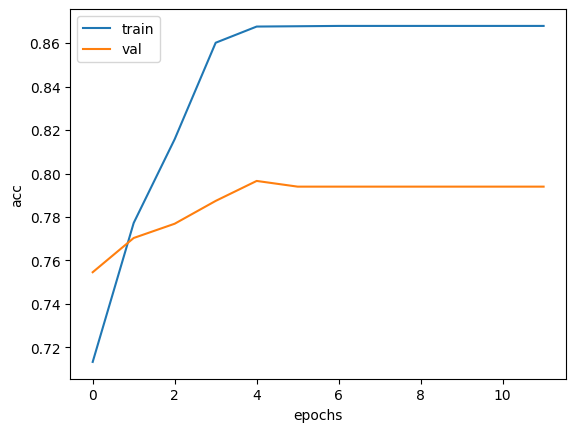

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'val'])
plt.ylabel('acc')
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

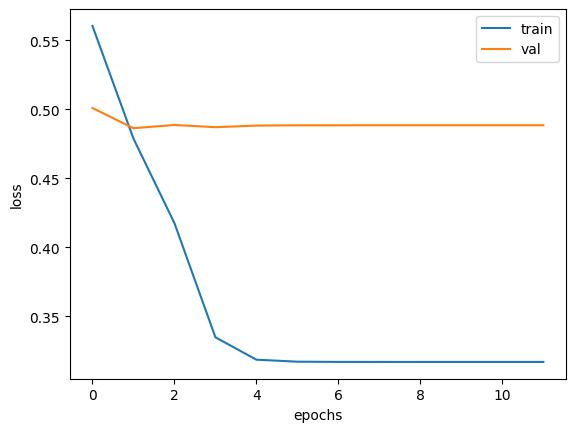

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'val'])
plt.ylabel('loss')
plt.xlabel('epochs')

### Test Submission

We need to preprocess the test set in the same way we did the training set before passing it to our model.

In [52]:
test = tokenizer.texts_to_sequences(df_test['text'].values)
test = pad_sequences(test)

(3263, 30)

In [40]:
test.shape #check test size

(3263, 25)

In [53]:
y_test = model.predict(test)

102/102 [==============================] - 1s 3ms/step


In [54]:
y_test

array([[0.28250492],
       [0.36809137],
       [0.8242046 ],
       ...,
       [0.88081914],
       [0.79957646],
       [0.3859091 ]], dtype=float32)

In [62]:
sample = pd.read_csv("sample_submission.csv")
sample['target'] = np.round(y_test)

In [68]:
sample = sample.astype('int')
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int32
 1   target  3263 non-null   int32
dtypes: int32(2)
memory usage: 25.6 KB


In [69]:
sample.to_csv("submission.csv", index = False)

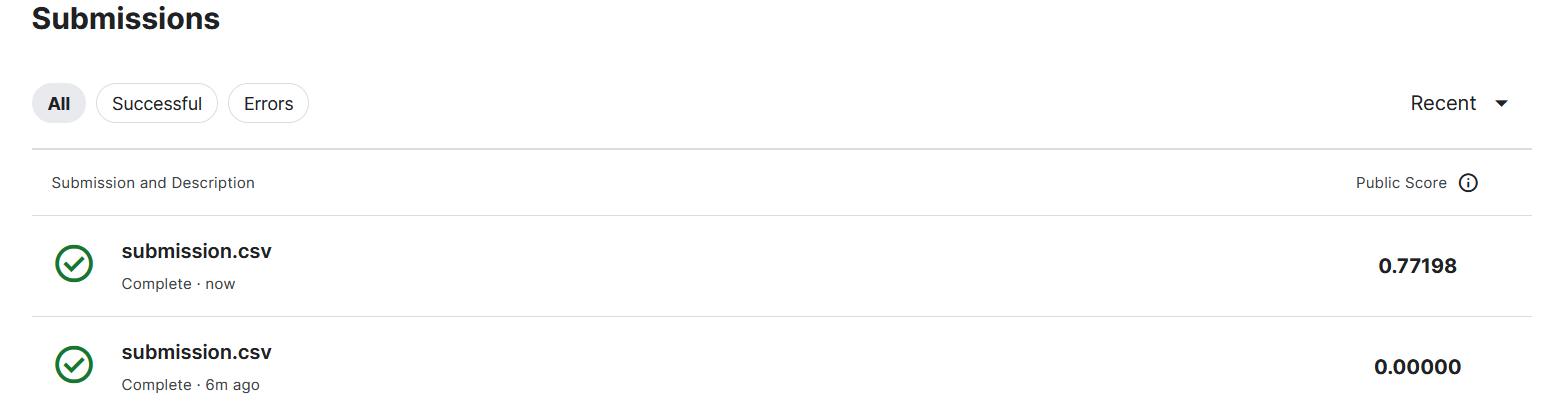